In [111]:
!python -V

Python 3.9.13


In [112]:
!dot -V

dot - graphviz version 6.0.1 (20220911.1526)


# dl box 5 のcuda指定

import torch
print(torch.cuda.current_device())

torch.cuda.set_device("cuda:3")
print(torch.cuda.current_device())

In [113]:
import os

root_path = os.getcwd()
root_path

'C:\\Users\\yoshi\\Desktop\\my_python\\script'

In [114]:
import torch

print(torch.__version__)

1.12.1


In [115]:
import torchvision

print(torchvision.__version__)

0.13.1


In [116]:
#https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [117]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [118]:
# CFIRデータ読み込み
trans = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     #RGBを-1~1に変換
    ])

png_path = str(root_path) + "\\cifar_PNG_train"

images = torchvision.datasets.ImageFolder(png_path, transform = trans)

batch_size = 64
trainloader = torch.utils.data.DataLoader(images, batch_size = batch_size, shuffle = True, num_workers=2)


png_path = str(root_path) + "\\cifar_PNG_test"
images_test = torchvision.datasets.ImageFolder(png_path, transform = trans)
testloader = torch.utils.data.DataLoader(images_test, batch_size = batch_size, shuffle = False, num_workers=2)


In [119]:


imgs, labels = iter(trainloader).next()

x = imgs[0].to('cpu').detach().numpy().copy()
x.shape

(3, 32, 32)

In [120]:
print("image shape ==>;",imgs[0].shape)

image shape ==>; torch.Size([3, 32, 32])


In [121]:
#torch.transpose(imgs[0], 0,2).shape

In [122]:
def unnorm(img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    def_img = img.detach().clone()
    for t, m, s in zip(def_img, mean, std):
        t.detach()
        t.mul_(s).add_(m)
    return def_img


Label is  5


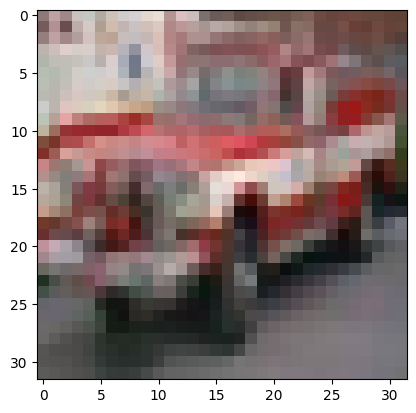

In [123]:
pic = transforms.ToPILImage(mode='RGB')(unnorm(imgs[2]))
plt.imshow(pic)
print("Label is ",labels[0].numpy())

In [124]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [125]:
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [126]:
from torchsummary import summary

In [127]:
summary(net, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [128]:
batch, label = next(iter(trainloader))

In [129]:
label

tensor([5, 7, 0, 9, 0, 7, 5, 5, 1, 8, 0, 0, 3, 9, 7, 6, 3, 0, 7, 5, 6, 2, 5, 0,
        5, 0, 7, 0, 1, 5, 0, 8, 7, 0, 4, 5, 2, 9, 3, 5, 4, 7, 0, 8, 3, 9, 9, 5,
        5, 5, 2, 3, 5, 9, 8, 8, 2, 9, 1, 5, 4, 8, 2, 1])

In [130]:
#data = torch.randn(3,32,32)

In [131]:
yhat = net(batch)

In [132]:
#!pip install graphviz

In [133]:
from torchviz import make_dot
#http://ruby.kyoto-wu.ac.jp/info-com/Softwares/Graphviz/
imim = make_dot(yhat)
imim.format = 'png'
imim.render('graph_image')

#graph vizのdotコマンドのpathを通すこと

'graph_image.png'

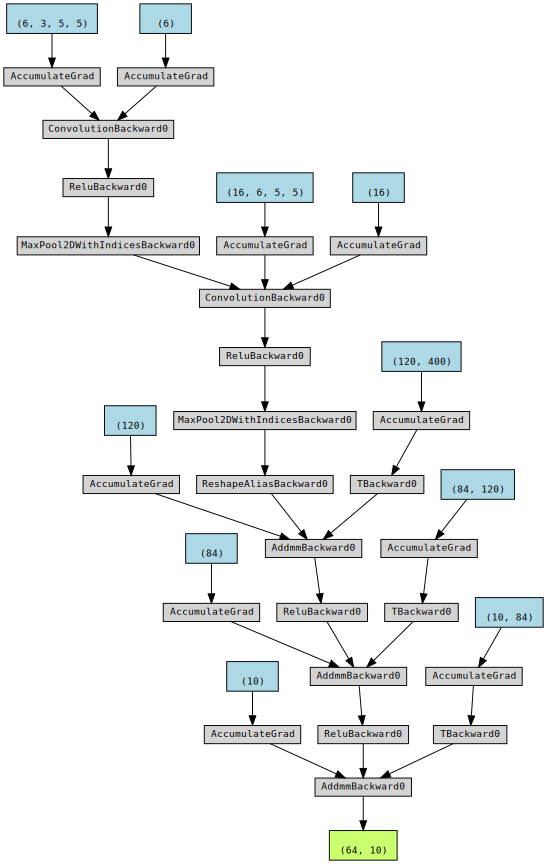

In [134]:
imim

In [135]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [136]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Finished Training


In [137]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [138]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
#imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

GroundTruth:  plane plane plane plane


In [139]:
#load

net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [140]:
outputs = net(images)

In [141]:
#from torchvision.io import read_image

#!wget 'https://images.unsplash.com/photo-1553284965-83fd3e82fa5a?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxleHBsb3JlLWZlZWR8NHx8fGVufDB8fHx8&w=1000&q=80'  -O white_horse.jpg
#white_torch = torchvision.io.read_image('white_horse.jpg')

from PIL import Image

im1 = torchvision.transforms.ToPILImage()(unnorm(images[0])).resize((100,100))
im2 = torchvision.transforms.ToPILImage()(unnorm(images[1])).resize((100,100))
im3 = torchvision.transforms.ToPILImage()(unnorm(images[2])).resize((100,100))
im4 = torchvision.transforms.ToPILImage()(unnorm(images[3])).resize((100,100))

def get_concat_h(im1, im2,im3,im4):
    dst = Image.new('RGB', (im1.width + im2.width +  im3.width + im4.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    dst.paste(im3, (im1.width + im2.width, 0))
    dst.paste(im4, (im1.width + im2.width + im3.width, 0))
    return dst



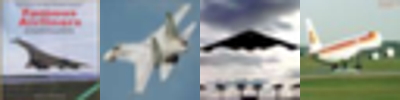

In [142]:
get_concat_h(im1, im2,im3,im4)#.save('data/dst/pillow_concat_h.jpg')


In [143]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  ship  plane horse ship 


In [144]:

stack_pred_label = []
stack_true_label = []

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        
        stack_true_label.extend(np.array(labels))

        
        
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        
        stack_pred_label.extend(np.array(predicted))
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 26 %


In [145]:
#!pip install seaborn

In [146]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:>

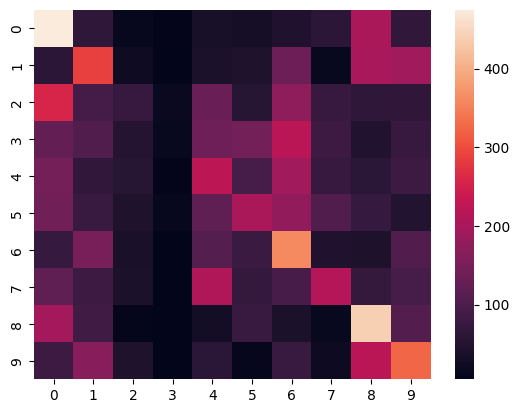

In [148]:

cm = confusion_matrix(stack_true_label, stack_pred_label)

#print(cm)
# [[1 4]
#  [3 2]]

sns.heatmap(cm)
#plt.savefig('data/dst/sklearn_confusion_matrix.png')

<AxesSubplot:>

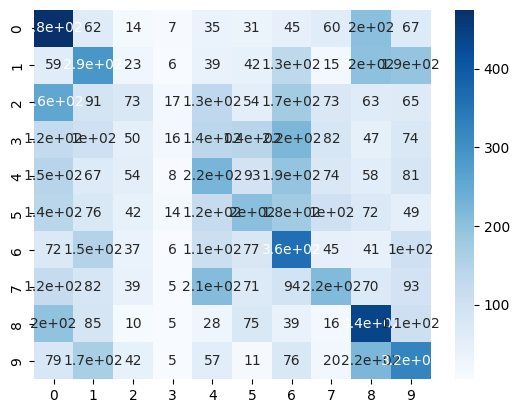

In [149]:
sns.heatmap(cm, annot=True, cmap='Blues')
#plt.savefig('data/dst/sklearn_confusion_matrix_annot_blues.png')

In [151]:
#!pip install mlxtend

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

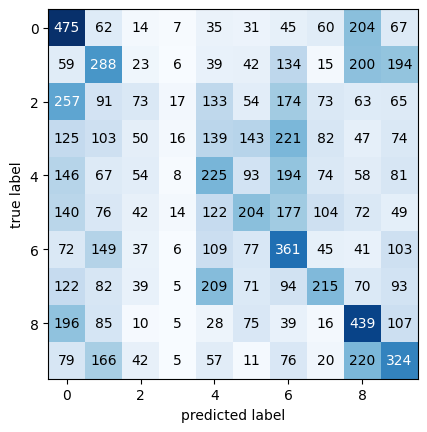

In [152]:
from mlxtend.plotting import plot_confusion_matrix
plot_confusion_matrix(conf_mat=cm)

(<Figure size 2000x2000 with 2 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

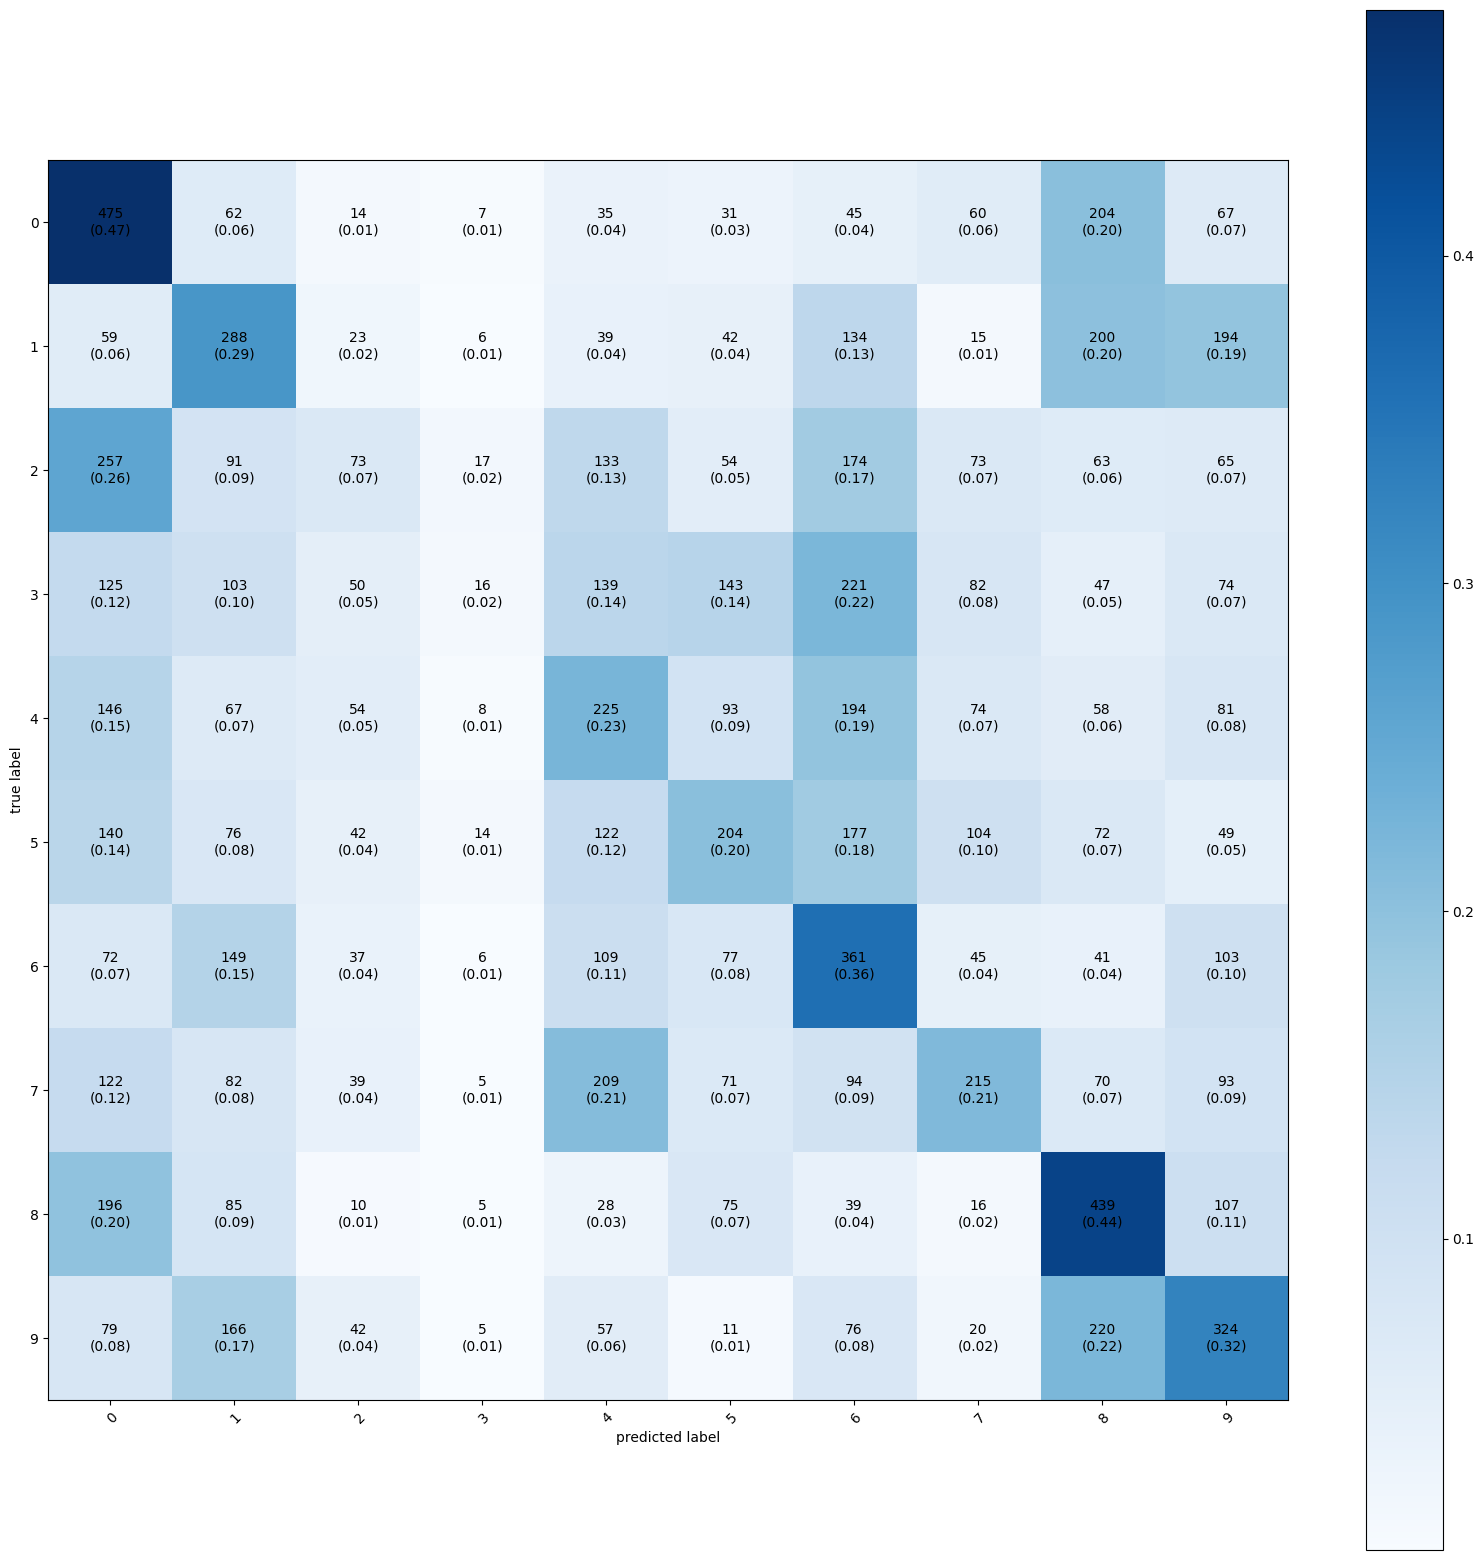

In [153]:
class_names=[0,1,2,3,4,5,6,7,8,9]

plot_confusion_matrix(conf_mat=cm,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,class_names=class_names, figsize=(20, 20), cmap='Blues')

In [154]:


# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 47.5 %
Accuracy for class: car   is 28.8 %
Accuracy for class: bird  is 7.3 %
Accuracy for class: cat   is 1.6 %
Accuracy for class: deer  is 22.5 %
Accuracy for class: dog   is 20.4 %
Accuracy for class: frog  is 36.1 %
Accuracy for class: horse is 21.5 %
Accuracy for class: ship  is 43.9 %
Accuracy for class: truck is 32.4 %


In [155]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


In [156]:
# GPUを使わせるには、以下を実行する。データとモデルをデバイスに送る
#net.to(device)
#inputs, labels = data[0].to(device), data[1].to(device)

# mnist net

In [157]:
mean = (0.5,)
std = (0.5,)

#mnist
trans = transforms.Compose([
    transforms.ToTensor(),
    torchvision.transforms.Grayscale(num_output_channels=1),
    transforms.Normalize(mean, std)
    ])

batch_size = 64

png_path = str(root_path) + "\\mnist_PNG_train"
images = torchvision.datasets.ImageFolder(png_path, transform = trans)

trainloader = torch.utils.data.DataLoader(images, batch_size = batch_size, shuffle = True, num_workers=2)

png_path = str(root_path) + "\\mnist_PNG_test"
images_test = torchvision.datasets.ImageFolder(png_path, transform = trans)
testloader = torch.utils.data.DataLoader(images_test, batch_size = batch_size, shuffle = False, num_workers=2)


In [158]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3) # 28x28x32 -> 26x26x32
        self.conv2 = nn.Conv2d(32, 64, 3) # 26x26x64 -> 24x24x64 
        self.pool = nn.MaxPool2d(2, 2) # 24x24x64 -> 12x12x64
        self.dropout1 = nn.Dropout()
        self.fc1 = nn.Linear(12 * 12 * 64, 128)
        self.dropout2 = nn.Dropout()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout1(x)
        x = x.view(-1, 12 * 12 * 64)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [159]:
net = Net()


In [160]:
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [161]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),
                      lr=0.0005, momentum=0.99, nesterov=True)

In [162]:
batch, label = next(iter(trainloader))

In [163]:
x = batch[0].to('cpu').detach().numpy().copy()
x.shape

(1, 28, 28)

In [164]:
yhat = net(batch)

imim = make_dot(yhat)
imim.format = 'png'
imim.render('mnist')


'mnist.png'

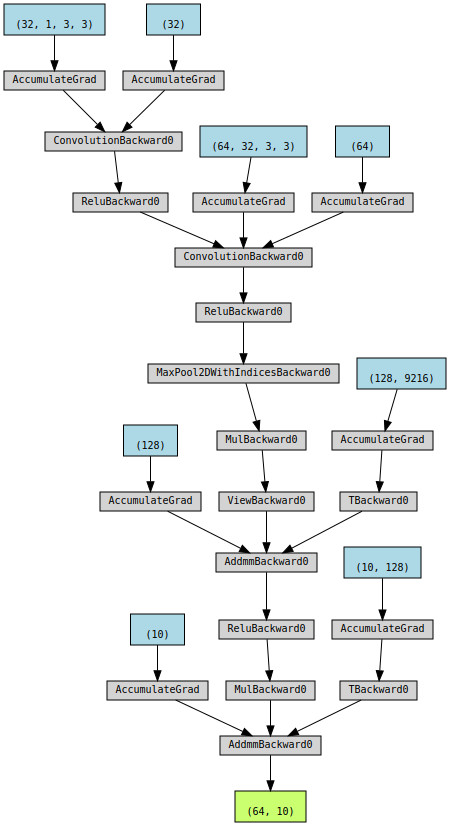

In [165]:
imim

In [166]:
epochs = 3

for epoch in range(epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:
            print('[{:d}, {:5d}] loss: {:.3f}'
                    .format(epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 2.219
[1,   200] loss: 1.179
[1,   300] loss: 0.622
[1,   400] loss: 0.498
[1,   500] loss: 0.388
[1,   600] loss: 0.336
[1,   700] loss: 0.294
[1,   800] loss: 0.253
[1,   900] loss: 0.229
[2,   100] loss: 0.190
[2,   200] loss: 0.167
[2,   300] loss: 0.170
[2,   400] loss: 0.167
[2,   500] loss: 0.158
[2,   600] loss: 0.146
[2,   700] loss: 0.130
[2,   800] loss: 0.139
[2,   900] loss: 0.132
[3,   100] loss: 0.114
[3,   200] loss: 0.114
[3,   300] loss: 0.118
[3,   400] loss: 0.117
[3,   500] loss: 0.117
[3,   600] loss: 0.113
[3,   700] loss: 0.098
[3,   800] loss: 0.095
[3,   900] loss: 0.094
Finished Training


In [167]:
correct = 0
total = 0

with torch.no_grad():
    for (images, labels) in testloader:
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy: {:.2f} %%'.format(100 * float(correct/total)))

Accuracy: 97.23 %%


In [168]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32,64, kernel_size=5)
        self.fc1 = nn.Linear(3*3*64, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.view(-1,3*3*64 )
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
net = Net()


In [169]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [171]:
%%time

#Seed
torch.manual_seed(1234)

for epoch in range(3):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:    # print every 500 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i+1, loss.item()))
#             print('[%d, %5d] loss: %.3f' % (epoch + 1, i, running_loss / 500))
#             running_loss = 0.0

print('Finished Training')


[1,   500] loss: 0.947
[2,   500] loss: 0.355
[3,   500] loss: 0.186
Finished Training
CPU times: total: 15min 35s
Wall time: 2min 33s


# make validation & transfer learning

In [172]:


#CFIR
trans = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     #RGBを-1~1に変換
    ])

png_path = str(root_path) + "\\cifar_PNG_train"

images = torchvision.datasets.ImageFolder(png_path, transform = trans)

batch_size = 640

trainloader = torch.utils.data.DataLoader(images, batch_size = batch_size, shuffle = True, num_workers=2)

png_path = str(root_path) + "\\cifar_PNG_test"
images_test = torchvision.datasets.ImageFolder(png_path, transform = trans)
testloader = torch.utils.data.DataLoader(images_test, batch_size = batch_size, shuffle = False, num_workers=2)



### mnist を読み込む場合

mean = (0.5,)
std = (0.5,)


trans = transforms.Compose([
    transforms.ToTensor(),
    torchvision.transforms.Grayscale(num_output_channels=1),
    transforms.Normalize(mean, std)
    ])

batch_size = 640

png_path = str(root_path) + "\\mnist_PNG_train"
images = torchvision.datasets.ImageFolder(png_path, transform = trans)


png_path = str(root_path) + "\\mnist_PNG_test"
images_test = torchvision.datasets.ImageFolder(png_path, transform = trans)
testloader = torch.utils.data.DataLoader(images_test, batch_size = batch_size, shuffle = False, num_workers=2)


In [173]:
n_samples = len(images)
train_size = int(n_samples * 0.8) 
val_size = n_samples - train_size 

train_dataset, val_dataset = torch.utils.data.random_split(images, [train_size, val_size])


In [174]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers=2)

valloader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle = True, num_workers=2)


In [175]:
import time
import copy
import os

In [176]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [177]:
from sklearn.metrics import accuracy_score

In [178]:

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    train_preds_stack = []
    train_true_stack = []
    val_preds_stack = []
    val_true_stack = []

    train_loss_ls = []
    train_accuracy_ls = []
    val_loss_ls = []
    val_accuracy_ls = []

    epoch_num = []

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        
        epoch_num.append(epoch)
        
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                
                total = 0
                correct = 0
                all_loss = 0
                for inputs, labels in trainloader:
                    
                    optimizer.zero_grad()
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                                        
                    loss.backward()
                    optimizer.step()
                                        
                    total += labels.size(0)
                    correct += (preds == labels).sum().item()
                    all_loss += loss.item()
                
                res_loss = (all_loss)# / total
                res_acc = (100 * correct / total)
                
                train_loss_ls.append(res_loss)
                train_accuracy_ls.append(res_acc)

                
            else:
                model.eval()   # Set model to evaluate mode

                with torch.set_grad_enabled(phase == 'val'):
                    
                    total = 0
                    correct = 0
                    all_loss = 0
                    
                    for inputs, labels in valloader:
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                                       
                        total += labels.size(0)
                        correct += (preds == labels).sum().item()
                        all_loss += loss.item()
                
                
                    res_loss = (all_loss) # / total
                    res_acc = (100 * correct / total)
                    
                    val_loss_ls.append(res_loss)
                    val_accuracy_ls.append(res_acc)
                    
                    #print(len(train_loss_ls))
                    #print(len(train_accuracy_ls))
                    #print(len(val_loss_ls))
                    #print(len(val_accuracy_ls))
                    
                    
                    epoch_loss = res_loss
                    epoch_acc = res_acc
                                        
                    print(str(phase) + " val_Loss: " + str(round(epoch_loss,5)) + " val_Acc: " + str(epoch_acc))

                
            if phase == 'train':
                scheduler.step()
                
            

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:    
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            ##############
            
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    
    plt.subplot(1,2,1)
    #plt.figure()
    #plt.title("Learning Curve")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    
    plt.plot(epoch_num, train_loss_ls, 'o-', color="r", label="Training loss")
    plt.plot(epoch_num, val_loss_ls, 'o-', color="g", label="Validation loss")
    plt.legend(loc='upper left')
    
    plt.subplot(1,2,2)
    plt.xlabel("epoch")
    plt.ylabel("acc")
    
    plt.plot(epoch_num, train_accuracy_ls, 'o-', color="r", label="Training acc")
    plt.plot(epoch_num, val_accuracy_ls, 'o-', color="g", label="Validation acc")
    plt.legend(loc='upper left')
    
    plt.show()


    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [179]:
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

C:\Users\yoshi\miniconda3\envs\py39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\yoshi\miniconda3\envs\py39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [180]:
model_ft.fc = nn.Linear(num_ftrs, 10)

In [181]:
# freeze layers except last layer
for param in model_ft.parameters():
    param.requires_grad = False

last_layer = list(model_ft.children())[-1]

print(f'except last layer: {last_layer}')
for param in last_layer.parameters():
    param.requires_grad = True

except last layer: Linear(in_features=512, out_features=10, bias=True)


In [182]:
# unfreeze all layers
#for param in model_ft.parameters():
#    param.requires_grad = True

In [183]:

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [184]:
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [185]:


#data_dir = str(root_path) + "\\cifar_PNG_train"

#dir 下にtrainとval フォルダがあるばあい,os.path.join(data_dir, x)
#image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(data_dir), data_transforms[x]) for x in ['train', 'val']}
#dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}

#dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
#class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [186]:
print(list(model_ft.parameters()))

[Parameter containing:
tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
            1.7083e-02, -1.2694e-02],
          [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
           -1.2907e-01,  3.7424e-03],
          [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
            2.5632e-01,  6.3573e-02],
          ...,
          [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
           -4.2058e-01, -2.5781e-01],
          [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
            3.9359e-01,  1.6606e-01],
          [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
           -8.2230e-02, -5.7828e-03]],

         [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
            6.6221e-04, -2.5743e-02],
          [ 4.5687e-02,  3.3603e-02, -1.0453e-01,  ..., -3.1253e-01,
           -1.6051e-01, -1.2826e-03],
          [-8.3730e-04,  9.8420e-02,  4.0210e-01,  ...,  7.0789e-01,
            3.6887e-01,  1.2455e-01

Epoch 0/14
----------
val val_Loss: 32.26937 val_Acc: 29.18
Epoch 1/14
----------
val val_Loss: 29.74834 val_Acc: 36.09
Epoch 2/14
----------
val val_Loss: 28.50019 val_Acc: 39.12
Epoch 3/14
----------
val val_Loss: 27.83236 val_Acc: 40.67
Epoch 4/14
----------
val val_Loss: 27.29711 val_Acc: 41.93
Epoch 5/14
----------
val val_Loss: 26.96502 val_Acc: 42.18
Epoch 6/14
----------
val val_Loss: 26.66702 val_Acc: 43.22
Epoch 7/14
----------
val val_Loss: 26.5919 val_Acc: 43.27
Epoch 8/14
----------
val val_Loss: 26.56429 val_Acc: 43.37
Epoch 9/14
----------
val val_Loss: 26.63335 val_Acc: 43.15
Epoch 10/14
----------
val val_Loss: 26.54049 val_Acc: 43.25
Epoch 11/14
----------
val val_Loss: 26.55523 val_Acc: 43.51
Epoch 12/14
----------
val val_Loss: 26.56067 val_Acc: 43.22
Epoch 13/14
----------
val val_Loss: 26.47248 val_Acc: 43.49
Epoch 14/14
----------
val val_Loss: 26.45162 val_Acc: 43.47
Training complete in 7m 10s
Best val Acc: 43.510000


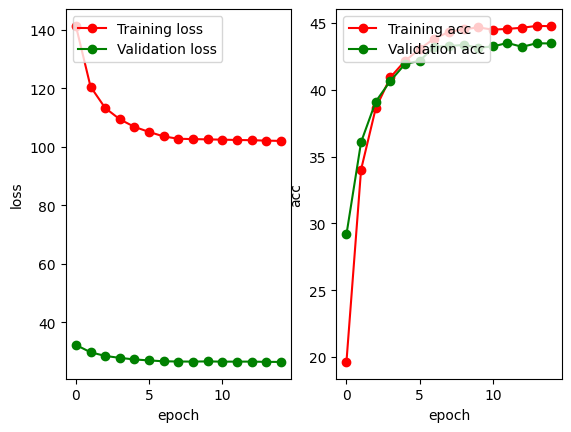

In [187]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=15)

In [188]:
print(list(model_ft.parameters()))


[Parameter containing:
tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
            1.7083e-02, -1.2694e-02],
          [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
           -1.2907e-01,  3.7424e-03],
          [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
            2.5632e-01,  6.3573e-02],
          ...,
          [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
           -4.2058e-01, -2.5781e-01],
          [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
            3.9359e-01,  1.6606e-01],
          [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
           -8.2230e-02, -5.7828e-03]],

         [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
            6.6221e-04, -2.5743e-02],
          [ 4.5687e-02,  3.3603e-02, -1.0453e-01,  ..., -3.1253e-01,
           -1.6051e-01, -1.2826e-03],
          [-8.3730e-04,  9.8420e-02,  4.0210e-01,  ...,  7.0789e-01,
            3.6887e-01,  1.2455e-01

# effici

In [189]:
from efficientnet_pytorch import EfficientNet


model_b0 = EfficientNet.from_pretrained('efficientnet-b0')
model_b7 = EfficientNet.from_pretrained('efficientnet-b7')

Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b7


In [190]:
#print(model_b0)

In [191]:
#print(model_b7)

In [192]:
num_ftrs = model_b0._fc.in_features
model_b0._fc = nn.Linear(num_ftrs, 10)

In [193]:
for param in model_b0.parameters():
    param.requires_grad = False

last_layer = list(model_b0.children())[7]

print(f'except last layer: {last_layer}')
for param in last_layer.parameters():
    param.requires_grad = True

except last layer: Linear(in_features=1280, out_features=10, bias=True)


In [194]:
list(model_b0.children())[7]

Linear(in_features=1280, out_features=10, bias=True)

In [195]:

model_b0.to(device)


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [196]:

#print(list(model_b0.parameters()))


Epoch 0/2
----------
val val_Loss: 35.61375 val_Acc: 20.33
Epoch 1/2
----------
val val_Loss: 33.05632 val_Acc: 32.8
Epoch 2/2
----------
val val_Loss: 30.7963 val_Acc: 37.14
Training complete in 3m 49s
Best val Acc: 37.140000


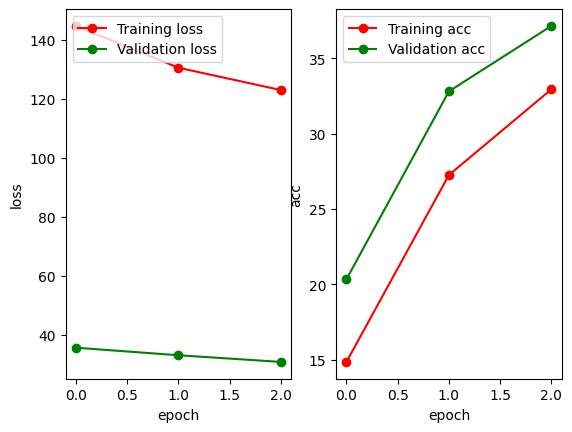

In [197]:


criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_b0.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_b0 = train_model(model_b0, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=3)

In [198]:
num_ftrs = model_b7._fc.in_features
model_b7._fc = nn.Linear(num_ftrs, 10)

# freeze layers except last layer
for param in model_b7.parameters():
    param.requires_grad = False

last_layer = list(model_b7.children())[7]

print(f'except last layer: {last_layer}')
for param in last_layer.parameters():
    param.requires_grad = True

except last layer: Linear(in_features=2560, out_features=10, bias=True)


Epoch 0/4
----------
val val_Loss: 40.26384 val_Acc: 9.94
Epoch 1/4
----------
val val_Loss: 39.33819 val_Acc: 10.66
Epoch 2/4
----------
val val_Loss: 42.4268 val_Acc: 12.6
Epoch 3/4
----------
val val_Loss: 32.95237 val_Acc: 27.18
Epoch 4/4
----------
val val_Loss: 32.68372 val_Acc: 28.6
Training complete in 38m 45s
Best val Acc: 28.600000


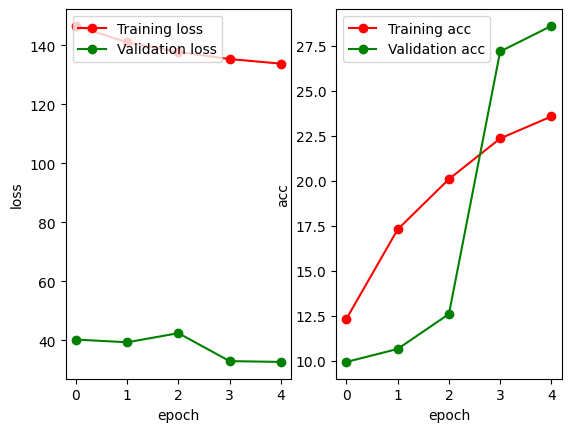

In [199]:
model_b7.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_b7.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_b0 = train_model(model_b7, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)